#**Variational Autoencoders on hand-written digits**

Variational autoencoders are probabilistic generative models with neural network components that are typically referred to as the encoder and decoder. The first neural network maps the input variable to a latent space that corresponds to the parameters of a variational distribution. In this way, the encoder can produce multiple different samples that all come from the same distribution. The decoder has the opposite function, which is to map from the latent space to the input space, in order to produce or generate data points. Both networks are typically trained together with the usage of the reparameterization trick, although the variance of the noise model can be learned separately.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

#### **MNIST dataset loading and pre-processing**


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000], y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

11493376/11490434 [==============================] - 0s 0us/step


## **The reparameterization trick**

The reparameterization trick in the Sampling layer is an important component of VAE. It allows to implement the sampling phase, while keeping the network trainable via gradient ascent/descent.
Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define the sample layer as a new layer.

To do this we define a new class that inherits from the layer base class tf.keras.layers that is used as base class for all the layers defined in Keras. In particular, from this class we are interested in overriding the call method, that is the one that is called when a layer is exploited by the model, and where the operations executed by the layer are defined.

In our case, the new Sampling layer has in input a mean vector $z_{\mu}$ and a ``variance'' vector $z_{\sigma}$, and it has to compute a sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{\mu} + exp(z_{\sigma}) \odot \epsilon,
$$
where $\epsilon$ is sampled by a normal distribution with zero mean and identity covariance matrix. 

In [ ]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_var = inputs
        epsilon = tf.keras.backend.random_normal(shape = (tf.shape(z_mean)[0], tf.shape(z_mean)[1]))
        return z_mean + tf.exp(z_var) * epsilon

**Note:** in this formula it makes sense to use $exp(z_{\sigma})$ instead of directly using $z_{\sigma}$. The following explains why.

In Direct Sample Generation we want drawing samples from a Normal Distribution with mean $\mu$ and covariance $\Sigma$ in order to obtain $z\sim\mathcal{N}(\mu,\Sigma)$. In practice we consider $\Sigma$ as a diagonal matrix in order to simplify the computational complexity of the training.

In particular $\mu = [\mu_{1},...,\mu_{k}]^{T}$ and $\Sigma = diag(\sigma_{1}^{2},...,\sigma_{k}^{2})$.

Therefore, the reparametrization trick takes the following form: 
$$
z = \mu + \sigma \odot \epsilon
$$
where $\epsilon \sim \mathcal{N}(0,I)$ and $I$ is the identity matrix.

However, we can rewrite the covariance matrix as
$$
\Sigma = diag(exp^{log(\sigma_{1}^{2})},...,exp^{log(\sigma_{k}^{2})})
$$
and by using the property of the logarithm we obtain 
$$
\Sigma = diag(exp^{2log(\sigma_{1})},...,exp^{2log(\sigma_{k})}).
$$

So in this notation the mean vector $z_{\mu}$ is exactly $\mu$ and the "variance" vector $z_{\sigma}$ corresponds to $log(\sigma)$ where $\sigma$ is the exact variance vector.

For this reason it makes sense to use $exp(z_{\sigma}) = exp(log(\sigma)) = \sigma$ instead of $z_{\sigma}$ in the reparametrization trick.

Thus the component of $z_{\sigma}$ can be also negative and this leads to a smoother representations for the Latent Space. On the other hand, the vector $exp(z_{\sigma})$ has always positive-valued components so it's a good way to represent the variance which must be a positive value. 

Alternatively, we could also have considered $z_{\sigma} = log(\sigma^{2}) = 2log(\sigma)$ but in that case we should have rewritten the reparametrization trick as:
$$
z = z_{\mu} + exp\biggl(\frac{z_{\sigma}}{2}\biggr) \odot \epsilon
$$
where $exp\biggl(\frac{z_{\sigma}}{2}\biggr) = exp\biggl(\frac{2log(\sigma)}{2}\biggr) = exp(log(\sigma)) = \sigma$.

#### **Encoder**

Now we define the encoder and then use the obtained encoding to compute $z_{\mu}$ and $z_\sigma$, by using two different dense layers. Finally, we use the Sampling layer to compute the sample $z$. 

In order to allow the visualization of the latent space, we will stick on a size of the latent space (i.e. the dimension of $z$) equal to $2$.

In [ ]:
latent_dim = 2

encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(128, activation='relu')(encoder_inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)

z_mean = tf.keras.layers.Dense(latent_dim, name = "z_mean")(x)
z_var = tf.keras.layers.Dense(latent_dim, name = "z_var")(x)
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          100480      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           8256        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 16)           1040        dense_1[0][0]                    
____________________________________________________________________________________________

I implemented an encoder whose layers size decreases more and more as we get closer to the two dense layers of maximum compression z_mean and z_var.

I tried to obtain a "coherent" architecture: consistently with the very small size of latent_dim = 2, I set the size of the last layer of the encoder to 16 and then I set the other layer sizes to values that are not too big w.r.t. 16. 

In particular I chose the ReLu activation function for all the encoder layers because it takes values in $[0,+\infty)$ so we have a large range of possible values to explore (on the other hand, if we use bounded ativation function like Sigmoid, which takes values in $[0,1]$, we have a restricted range of possible values). As a result we can obtain a larger range of values for z_mean and z_var by using ReLu in the encoder.

####**Decoder**

The decoder part has in input $z$ and returns its "decoding". Its topology will have a mirror shape w.r.t. the encoder.

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(16, activation='relu')(latent_inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid')(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_4 (Dense)              (None, 64)                1088      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 784)               101136    
Total params: 110,592
Trainable params: 110,592
Non-trainable params: 0
_________________________________________________________________


The number, size and activation function of the layers are specular to the encoder ones: in this way we obtain a network which is similar to an undercomplete autoencoder. The difference is that the encoder terminates with two dense layers of size two (=latent_dim) which define the latent state distributions and the decoder takes in input a sample of the same size from those distributions, computed by the reparametrization trick.

Of course the last layer has the same size as the encoder_input layer because the task of an autoencoder is to reconstruct the input. For this reason, I set the Sigmoid activation function for the last layer of the decoder, in fact our dataset is composed by vectors whose components take values in [0,1] so it's better to choose a bounded activation function that takes values in [0,1]. 

## **Model fitting and analysis**

Now we can define the VAE, but since it is a generative model, we have to define an ad hoc training phase. In particular, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss that forces the decoded samples to match the original inputs, and a regularization loss that helps to learn well-formed latent spaces (Gaussian prior) and reduces overfitting to the training data. The regularization loss involves the Kullback-Liebler Divergence. While for the reconstruction loss we are supposed to use the negative log-likelihood. Keras, however, does not support it natively, so to make the exercise simple, we will use as a proxy the binary cross-entropy to compare each feature of a data point to the value in the reconstructed output.

Therefore, we have to define a class that inherits from [keras.model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and overrides the [training_step method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step), that allows to define a custom training logic.

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_var, z = encoder(data)
            reconstruction = decoder(z)


            reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction))*784

            # Kullback-Liebler Divergence: - (1 + log(sigma^2) - mu^2 - sigma^2)/2
            # Since we considered z_mean = mu and z_var = log(sigma) then:
            # 1) log(sigma^2) = 2*log(sigma) = 2*z_var
            # 2) sigma^2 = exp(log(sigma^2)) = exp(2*log(sigma)) = exp(2*z_var)

            kl_loss = - tf.reduce_mean(1 + 2*z_var - tf.square(z_mean) - tf.exp(2*z_var))/2

            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

Epoch 1/30
391/391 [==============================] - 4s 9ms/step - loss: 208.4386 - reconstruction_loss: 203.8328 - kl_loss: 4.6058
Epoch 2/30
391/391 [==============================] - 4s 9ms/step - loss: 171.4800 - reconstruction_loss: 168.6690 - kl_loss: 2.8110
Epoch 3/30
391/391 [==============================] - 4s 9ms/step - loss: 165.0549 - reconstruction_loss: 162.1321 - kl_loss: 2.9228
Epoch 4/30
391/391 [==============================] - 4s 9ms/step - loss: 161.4606 - reconstruction_loss: 158.4399 - kl_loss: 3.0206
Epoch 5/30
391/391 [==============================] - 4s 10ms/step - loss: 158.5298 - reconstruction_loss: 155.4081 - kl_loss: 3.1217
Epoch 6/30
391/391 [==============================] - 4s 9ms/step - loss: 155.8084 - reconstruction_loss: 152.5947 - kl_loss: 3.2137
Epoch 7/30
391/391 [==============================] - 4s 9ms/step - loss: 153.8082 - reconstruction_loss: 150.5282 - kl_loss: 3.2800
Epoch 8/30
391/391 [==============================] - 4s 9ms/step - 

We can now plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate several  2D $\hat{z}$ samples and pass them to our decoder. The interval where to sample  $\hat{z}$ can be controlled by the $scale$ parameter, while the number of generated samples is controlled by the $n$ parameter.


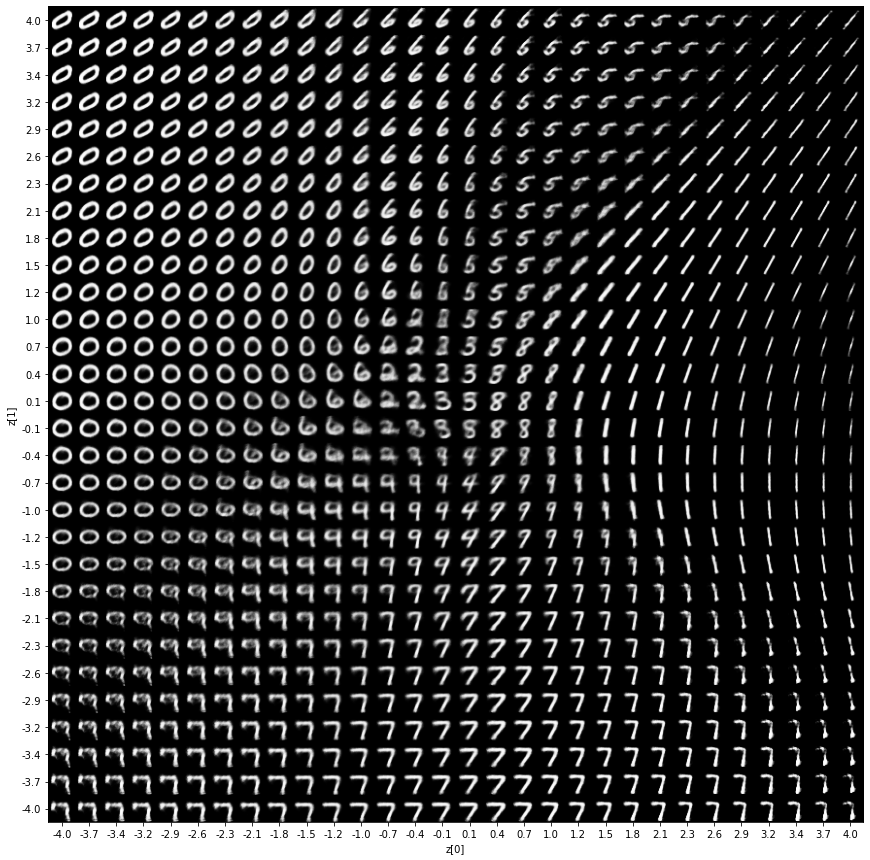

In [ ]:
def plot_latent(encoder, decoder, scale, n):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder, 4.0, 30) 

#To complete: explore with different "scale"

Let's finaly check how the different digits have been rapresented in the latent space by the VAE.

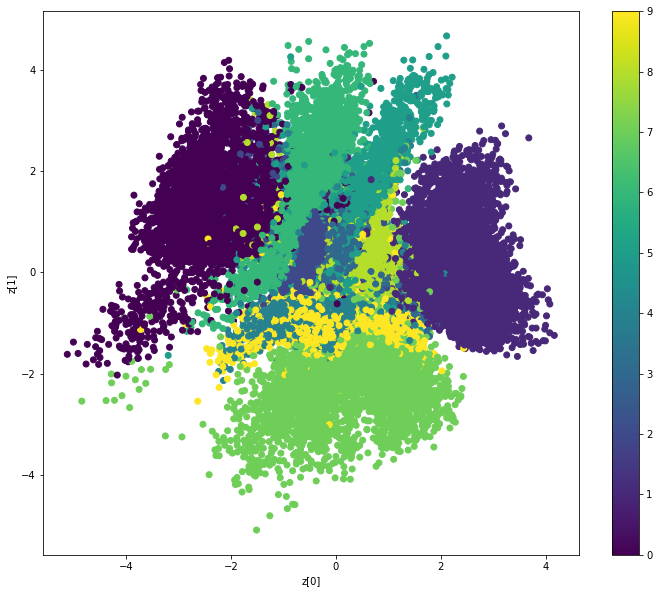

In [ ]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train)

####**Discussion: How the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result.**

By using just two latent variables z[0] and z[1] we obtained a well organized latent space: in the two plots we can observe how the output $\tilde{x}$ of the decoder changes as we move along the orizzontal axis (i.e. as we vary z[0]) or the vertical axis (i.e. as we vary z[1]). 

The first plot shows the images generated by the decoder whose input is sampled from a range of values defined by the parameter 'scale': $\hat{z}$ takes value of the components in the vector np.linspace(-scale, scale, n) composed by n values equally distributed in the rage [-scale,scale].

On the other hand, the second plot consideres the two components of z_mean predicted by the encoder whose input is x_train i.e. the training dataset (we're not sampling from a linspace vector as in the previous plot!) and shows how the target value of the data, i.e. the label which indicates the digit represented in each input image, varies according to the z_mean components.

So it makes sense to use the same range of values in both plots in order to make a comparison: for this reason I set 'scale' = 4.0.
We can easily note that the second plot is coherent with the first one, in the sense that if we consider a space region in the second plot in which one colour (representing one target value) is preponderant, then the correspondent region in the first plot shows images whose target values would be the same considered in the first plot. Thus the two plots represent the way in which the different digit classes are distributed in the latent space.

We can deduce from this that the variational autoencoder stored all the relevant features of the data in a compressed representation (latent space showed in the two plots), in a way that there is enough information to reconstruct the original data. In particular, two similar images (which show a similar path) are represented close togheter in the latent space: we can observe that '7' gradually vanishes and becames '1' which gradually becames '8' and then '9' and then '0' and so on, depending on which direction we are moving through the plot.

In conclusion, if we change the hyper-parameters of the VAE the plot changes too.

At first, I experimented in changing the size of the three encoder and decoder layers and tried with different combinations: 128-64-16 , 64-32-16, 256-128-64, 512-256-128, 512-128-16. As a result I obtained different shapes of clusters and in some cases (512-128-16 and 64-32-16) the same digit class was represented in two separated clusters (the network didn't efficiently store the relevant features of the data). However, in all these cases, the positions of the different clusters in the plot changed but some "relative" positions didn't:
* '7' remains close to '1' and '9'
* '8' remains close to '1' and '5'
* '0' remains close to '6'
* '9' remains close to '4'

Then, I experimented in changing the number of the encoder and decoder layers: I considered two layers with size 128-32, four layers with size 256-128-64-32 and five layers with size 512-256-128-64-32. It seems that with four or five layers it is more recurrent the phenomenon in which the same digit class is represented in two separated clusters, maybe because a deeper network results in a more complex feature representation. 
